# Stroke Prognosis: Prueba de los Modelos

<p>
Curso de Minería de Datos <br>
Autor: Cristian Pavez Hormazábal
</p>

In [1]:
# Importación de librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import random

import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import yellowbrick as yb
from yellowbrick.classifier import ConfusionMatrix


In [2]:
# Importación de datos
dataset = pd.read_csv("all-data.csv")

# Formateo de los datos
dataset.drop("id", axis=1, inplace=True)
dataset['gender'] = dataset['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
dataset['ever_married'] = dataset['ever_married'].map({'Yes': 1, 'No': 0})
dataset['work_type'] = dataset['work_type'].map({'Private': 4, 'Self-employed': 2, 'Govt_job': 3, 'children': 1, 'Never_worked': 0})
dataset['Residence_type'] = dataset['Residence_type'].map({'Rural': 0, 'Urban': 1})
dataset['smoking_status'] = dataset['smoking_status'].map({'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2, 'smokes': 3})

# Eliminar filas con valores perdidos
dataset_no_bmi = dataset.drop("bmi", axis=1)
dataset = dataset.dropna()

# Dividir el dataset en personas con y sin stroke
stroke_data = dataset[dataset['stroke'] == 1]
no_stroke_data = dataset[dataset['stroke'] == 0]

# Sobre-representar los datos de stroke
stroke_data_overrepresented = pd.concat([stroke_data] * 10, ignore_index=True)

# Combinar los datasets
balanced_dataset = pd.concat([stroke_data_overrepresented, no_stroke_data], ignore_index=True)

# Mezclar los datos para evitar orden
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Segundo Balanceo
# Dividir el dataset en personas con y sin stroke
stroke_data = dataset_no_bmi[dataset_no_bmi['stroke'] == 1]
no_stroke_data = dataset_no_bmi[dataset_no_bmi['stroke'] == 0]

# Sobre-representar los datos de stroke
stroke_data_overrepresented = pd.concat([stroke_data] * 10, ignore_index=True)

# Combinar los datasets
balanced_dataset2 = pd.concat([stroke_data_overrepresented, no_stroke_data], ignore_index=True)

# Mezclar los datos para evitar orden
balanced_dataset2 = balanced_dataset2.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el balance
print('Dataset original:', dataset['stroke'].value_counts())
print('Dataset sin IMC:', dataset_no_bmi['stroke'].value_counts())
print('Dataset original balanceado:', balanced_dataset['stroke'].value_counts())
print('Dataset sin IMC balanceado:', balanced_dataset2['stroke'].value_counts())

Dataset original: stroke
0    4700
1     209
Name: count, dtype: int64
Dataset sin IMC: stroke
0    4861
1     249
Name: count, dtype: int64
Dataset original balanceado: stroke
0    4700
1    2090
Name: count, dtype: int64
Dataset sin IMC balanceado: stroke
0    4861
1    2490
Name: count, dtype: int64


In [3]:
# Configuración de los sets de entrenamiento y prueba para cada set
def set_training_and_test(dataset):

    training_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']

    x = dataset[training_columns]
    y = dataset['stroke']

    x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state = random.randint(0,100), test_size=0.2, shuffle=True)

    return x_train, x_test, y_train, y_test

def set_training_and_test2(dataset):

    training_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'smoking_status']

    x = dataset[training_columns]
    y = dataset['stroke']

    x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state = random.randint(0,100), test_size=0.2, shuffle=True)

    return x_train, x_test, y_train, y_test

In [ ]:
# Función para probar modelos
def prueba_modelos(dataset, model_name, model, dataset_name):
    vp = []
    vn = []
    fp = []
    fn = []
    accuracy = []
    precision = []
    recall = []
    for i in range(1, 10):
        naive_bayes = model
        x_train, x_test, y_train, y_test = set_training_and_test(dataset)
        naive_bayes.fit(x_train, y_train)
        previsoes = naive_bayes.predict(x_test)

        # Evaluación del modelo
        vp.append(np.sum((previsoes == 1) & (y_test == 1)))
        vn.append(np.sum((previsoes == 0) & (y_test == 0)))
        fp.append(np.sum((previsoes == 1) & (y_test == 0)))
        fn.append(np.sum((previsoes == 0) & (y_test == 1)))
        accuracy.append((vp[-1] + vn[-1]) / len(y_test))
        precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
        recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

    # Imprimir CM
    vp_promedio = np.mean(vp)
    vn_promedio = np.mean(vn)
    fp_promedio = np.mean(fp)
    fn_promedio = np.mean(fn)

    print(f"{model_name} para el dataset {dataset_name}:")
    print(f"\tVP: {vp_promedio}, FN: {fn_promedio} \n\tFP: {fp_promedio}, VN: {vn_promedio}")
    print(f"\tAccuracy: {np.mean(accuracy)}")
    print(f"\tPrecision: {np.mean(precision)}")
    print(f"\tRecall: {np.mean(recall)}")

    # Imprimir promedios de la metricas
    print(f"\tVP promedio: {vp_promedio}\tVN promedio: {vn_promedio}")
    print(f"\tFP promedio: {fp_promedio}\tFN promedio: {fn_promedio}")

    print(f"\tAccuracy promedio: {np.mean(accuracy)}")
    print(f"\tPrecision promedio: {np.mean(precision)}")
    print(f"\tRecall promedio: {np.mean(recall)}")

    # Boxplot para VP, VN, FP, FN
    data = {
        'VP': vp,
        'VN': vn,
        'FP': fp,
        'FN': fn
    }
    df = pd.DataFrame(data)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title(f'Boxplot de VP, VN, FP, FN para {model_name} en {dataset_name}')
    plt.ylabel('Valores')
    plt.show()

    # Boxplot para Accuracy, Precision, Recall
    data_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }
    df_metrics = pd.DataFrame(data_metrics)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_metrics)
    plt.ylim(0, 1)
    plt.title(f'Boxplot de Accuracy, Precision, Recall para {model_name} en {dataset_name}')
    plt.ylabel('Valores')
    plt.show()

def prueba_modelos2(dataset, model_name, model, dataset_name):
    vp = []
    vn = []
    fp = []
    fn = []
    accuracy = []
    precision = []
    recall = []
    for i in range(1, 10):
        naive_bayes = model
        x_train, x_test, y_train, y_test = set_training_and_test2(dataset)
        naive_bayes.fit(x_train, y_train)
        previsoes = naive_bayes.predict(x_test)

        # Evaluación del modelo
        vp.append(np.sum((previsoes == 1) & (y_test == 1)))
        vn.append(np.sum((previsoes == 0) & (y_test == 0)))
        fp.append(np.sum((previsoes == 1) & (y_test == 0)))
        fn.append(np.sum((previsoes == 0) & (y_test == 1)))
        accuracy.append((vp[-1] + vn[-1]) / len(y_test))
        precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
        recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

    # Imprimir CM
    vp_promedio = np.mean(vp)
    vn_promedio = np.mean(vn)
    fp_promedio = np.mean(fp)
    fn_promedio = np.mean(fn)

    print(f"{model_name} para el dataset {dataset_name}:")
    print(f"\tVP: {vp_promedio}, FN: {fn_promedio} \n\tFP: {fp_promedio}, VN: {vn_promedio}")
    print(f"\tAccuracy: {np.mean(accuracy)}")
    print(f"\tPrecision: {np.mean(precision)}")
    print(f"\tRecall: {np.mean(recall)}")

    # Boxplot para VP, VN, FP, FN
    data = {
        'VP': vp,
        'VN': vn,
        'FP': fp,
        'FN': fn
    }
    df = pd.DataFrame(data)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title(f'Boxplot de VP, VN, FP, FN para {model_name} en {dataset_name}')
    plt.ylabel('Valores')
    plt.show()

    # Boxplot para Accuracy, Precision, Recall
    data_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }
    df_metrics = pd.DataFrame(data_metrics)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_metrics)
    plt.ylim(0, 1)
    plt.title(f'Boxplot de Accuracy, Precision, Recall para {model_name} en {dataset_name}')
    plt.ylabel('Valores')
    plt.show()




Gaussian Naive Bayes para el dataset sin Null:
	VP: 17.555555555555557, FN: 24.0 
	FP: 104.88888888888889, VN: 835.5555555555555
	Accuracy: 0.8687485856528626
	Precision: 0.14358248790138356
	Recall: 0.429087560950306


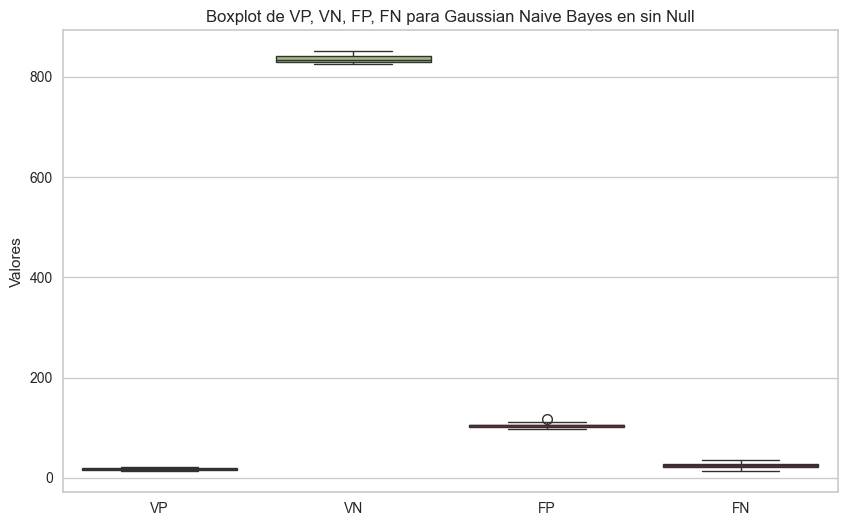

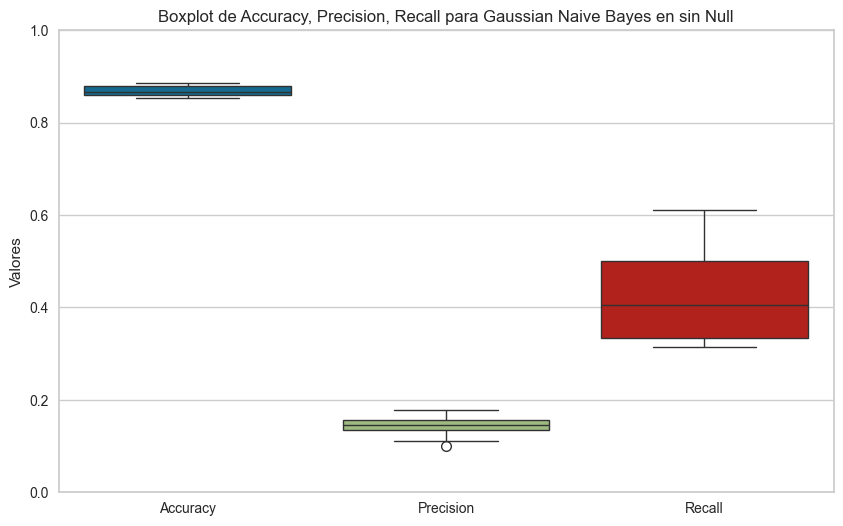

Gaussian Naive Bayes para el dataset sin Null balanceado:
	VP: 248.22222222222223, FN: 167.22222222222223 
	FP: 161.55555555555554, VN: 781.0
	Accuracy: 0.7578955981017836
	Precision: 0.6061412372286805
	Recall: 0.5976016857275649


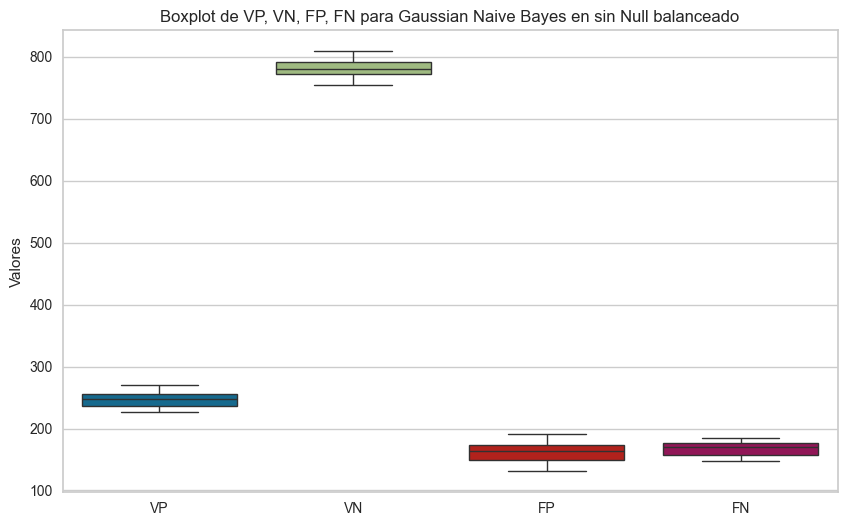

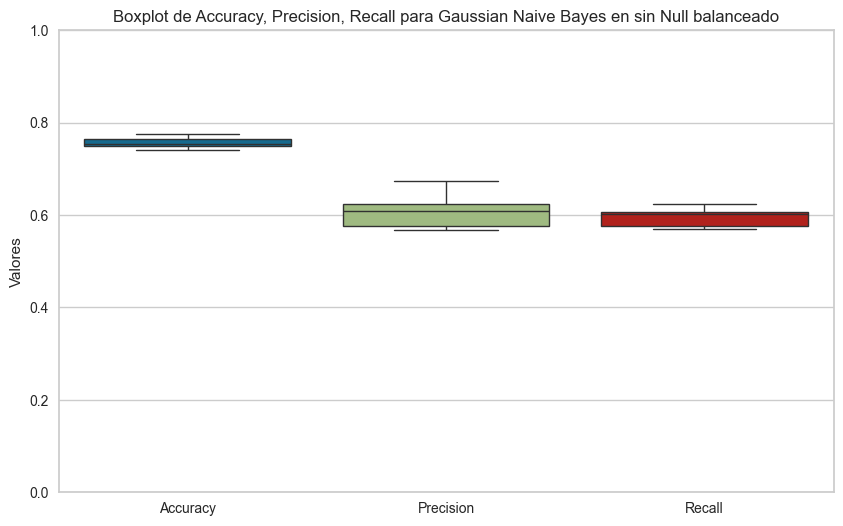

Gaussian Naive Bayes para el dataset sin IMC:
	VP: 18.88888888888889, FN: 30.444444444444443 
	FP: 105.0, VN: 867.6666666666666
	Accuracy: 0.8674711893889975
	Precision: 0.15434544668977723
	Recall: 0.3840205989714396


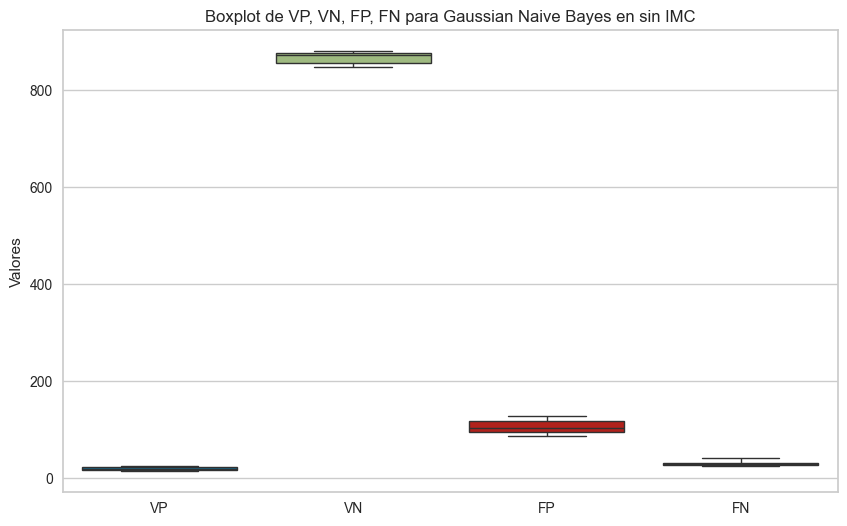

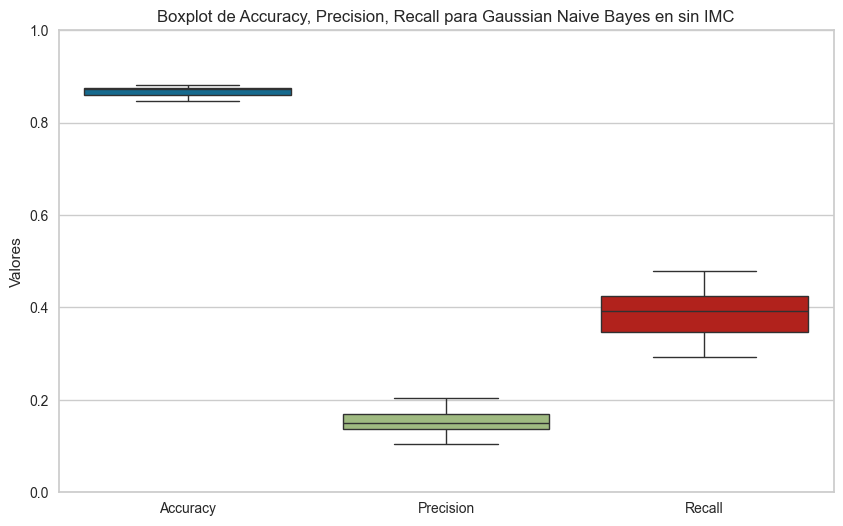

Gaussian Naive Bayes para el dataset sin IMC balanceado:
	VP: 298.77777777777777, FN: 192.33333333333334 
	FP: 181.22222222222223, VN: 798.6666666666666
	Accuracy: 0.7460533272905807
	Precision: 0.6226559724023896
	Recall: 0.6084429884831617


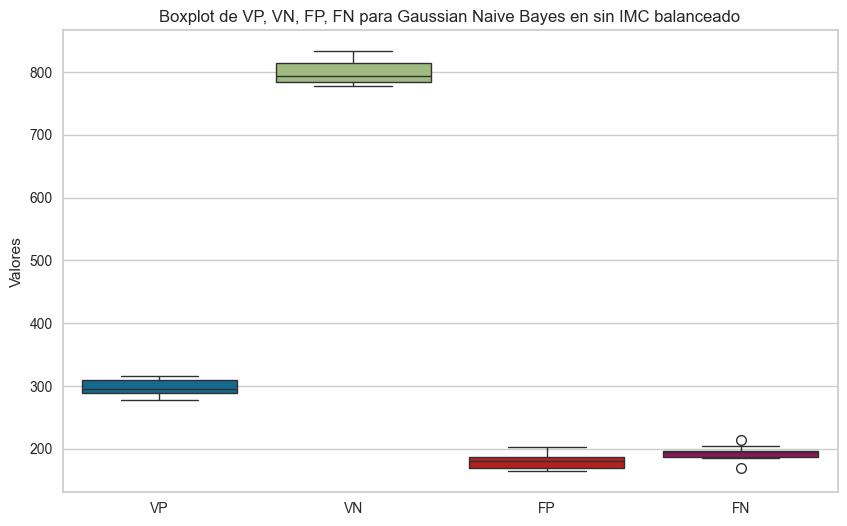

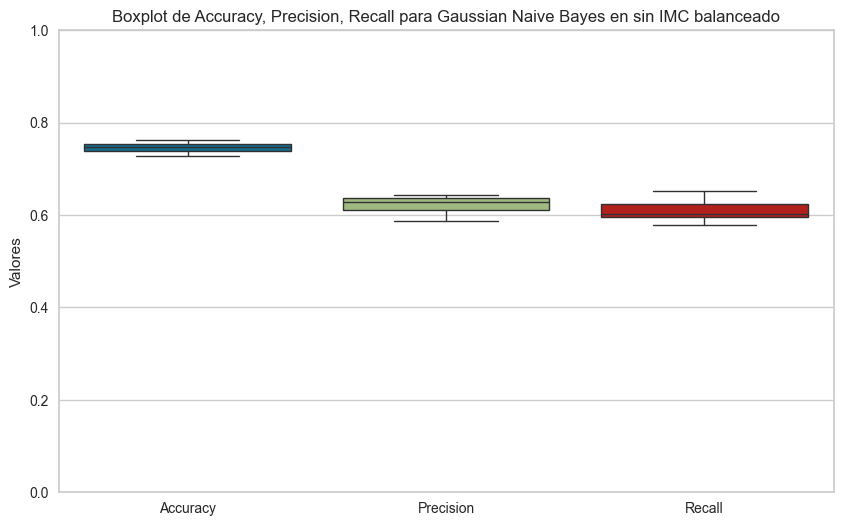

In [14]:
# Gaussian Naive Bayes
prueba_modelos(dataset, "Gaussian Naive Bayes", sk.naive_bayes.GaussianNB(), "sin Null")
prueba_modelos(balanced_dataset, "Gaussian Naive Bayes", sk.naive_bayes.GaussianNB(), "sin Null balanceado")
prueba_modelos2(dataset_no_bmi, "Gaussian Naive Bayes", sk.naive_bayes.GaussianNB(), "sin IMC")
prueba_modelos2(balanced_dataset2, "Gaussian Naive Bayes", sk.naive_bayes.GaussianNB(), "sin IMC balanceado")



Bernoulli Naive Bayes para el dataset sin Null:
	VP: 0.8888888888888888, FN: 42.888888888888886 
	FP: 6.0, VN: 932.2222222222222
	Accuracy: 0.9502149807648789
	Precision: 0.14285714285714285
	Recall: 0.019635508524397414


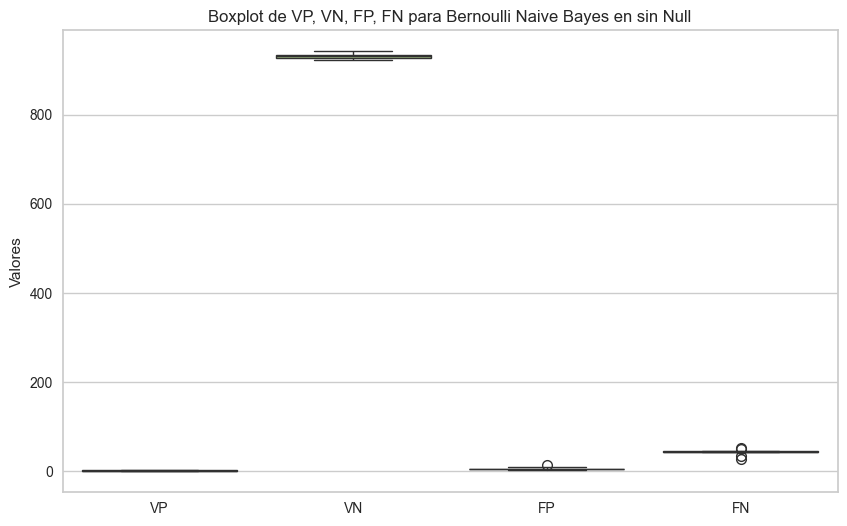

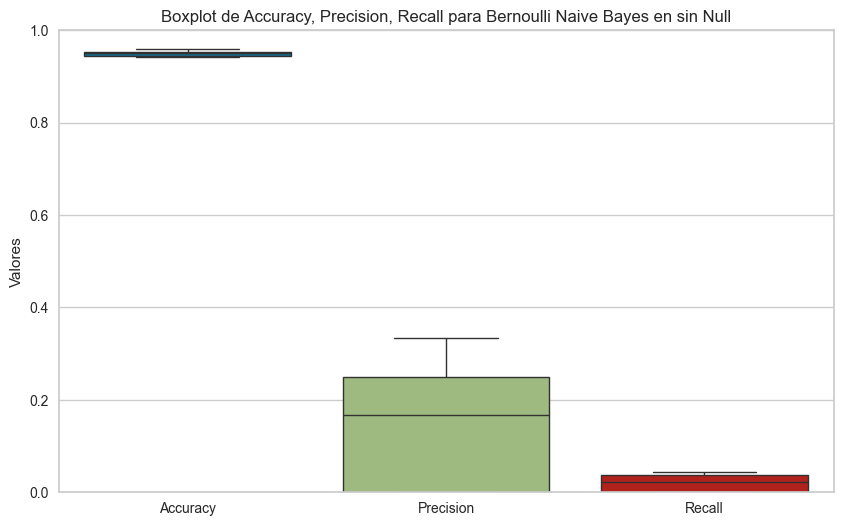

Bernoulli Naive Bayes para el dataset sin Null balanceado:
	VP: 148.22222222222223, FN: 268.22222222222223 
	FP: 93.0, VN: 848.5555555555555
	Accuracy: 0.7340042546228114
	Precision: 0.6151979685324787
	Recall: 0.35607104690538127


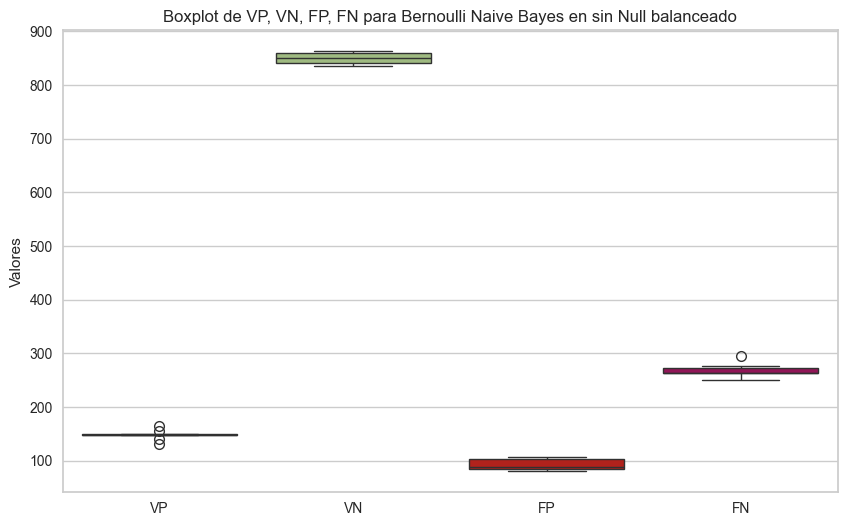

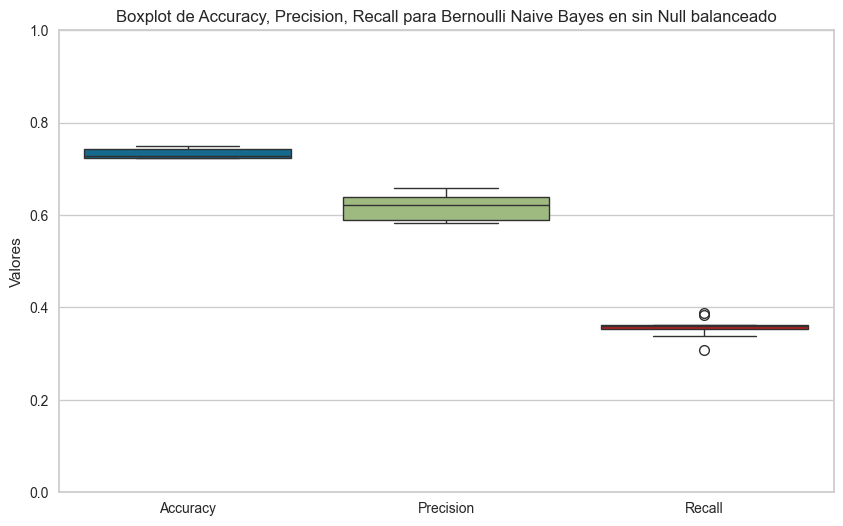

Bernoulli Naive Bayes para el dataset sin IMC:
	VP: 0.7777777777777778, FN: 48.77777777777778 
	FP: 4.555555555555555, VN: 967.8888888888889
	Accuracy: 0.9478147423352902
	Precision: 0.19921436588103253
	Recall: 0.015139871823810849


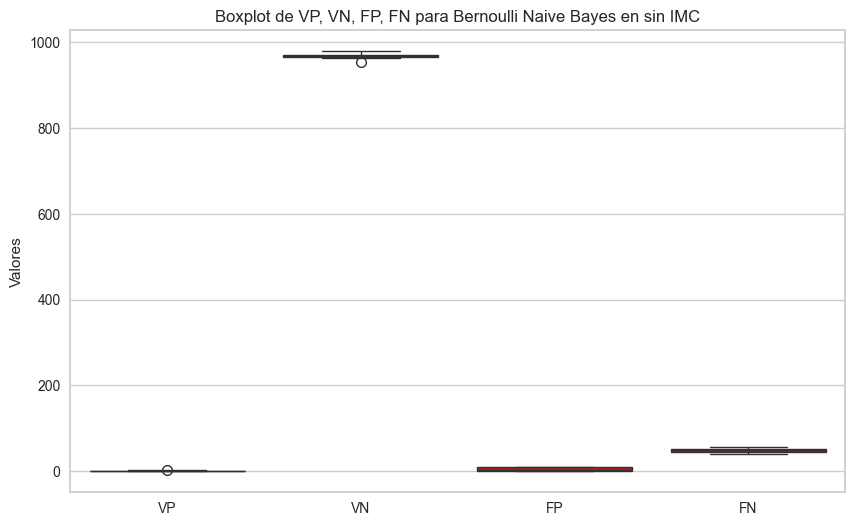

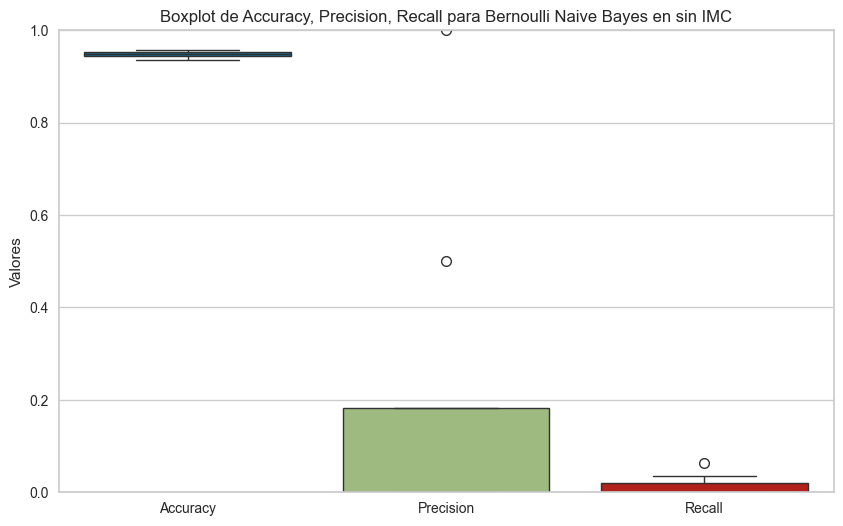

Bernoulli Naive Bayes para el dataset sin IMC balanceado:
	VP: 178.55555555555554, FN: 319.0 
	FP: 112.88888888888889, VN: 860.5555555555555
	Accuracy: 0.7063977641815848
	Precision: 0.6126884869122852
	Recall: 0.3588064514232058


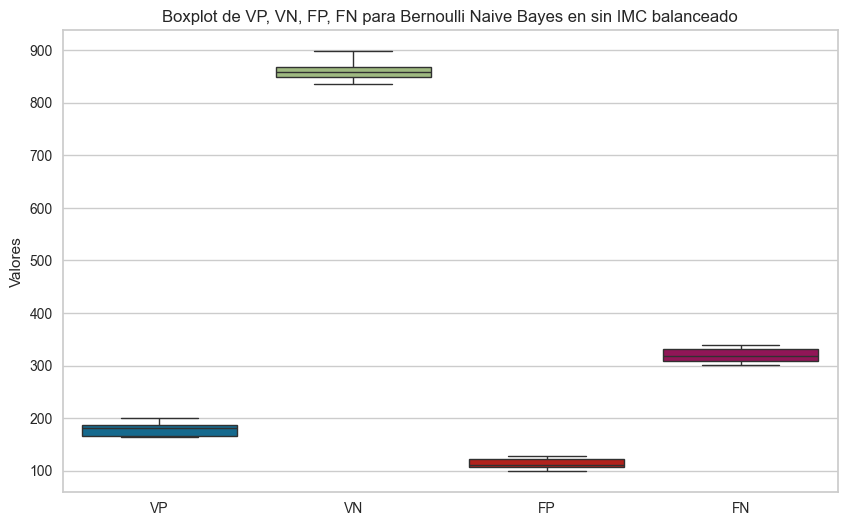

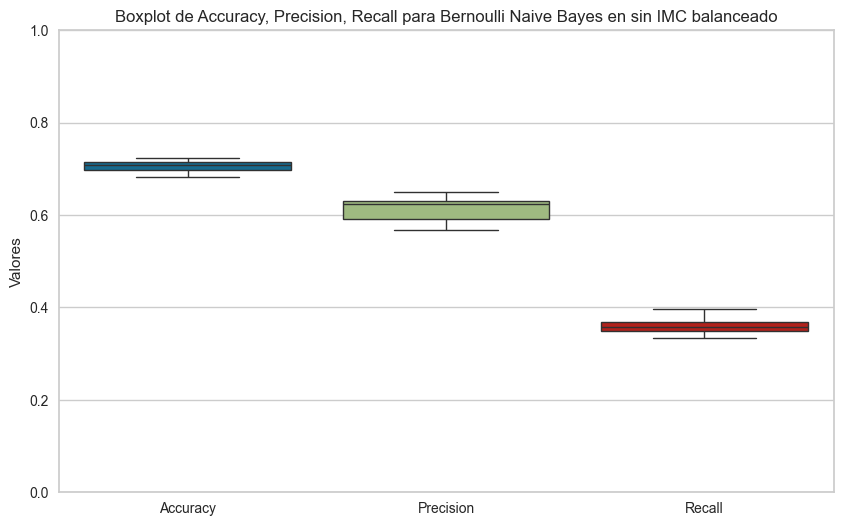

In [15]:
# Bernoulli Naive Bayes
prueba_modelos(dataset, "Bernoulli Naive Bayes", sk.naive_bayes.BernoulliNB(), "sin Null")
prueba_modelos(balanced_dataset, "Bernoulli Naive Bayes", sk.naive_bayes.BernoulliNB(), "sin Null balanceado")
prueba_modelos2(dataset_no_bmi, "Bernoulli Naive Bayes", sk.naive_bayes.BernoulliNB(), "sin IMC")
prueba_modelos2(balanced_dataset2, "Bernoulli Naive Bayes", sk.naive_bayes.BernoulliNB(), "sin IMC balanceado")



Decision Tree para el dataset sin Null:
	VP: 5.666666666666667, FN: 35.22222222222222 
	FP: 40.55555555555556, VN: 900.5555555555555
	Accuracy: 0.9228332201855624
	Precision: 0.12327155722166475
	Recall: 0.14108483027934904


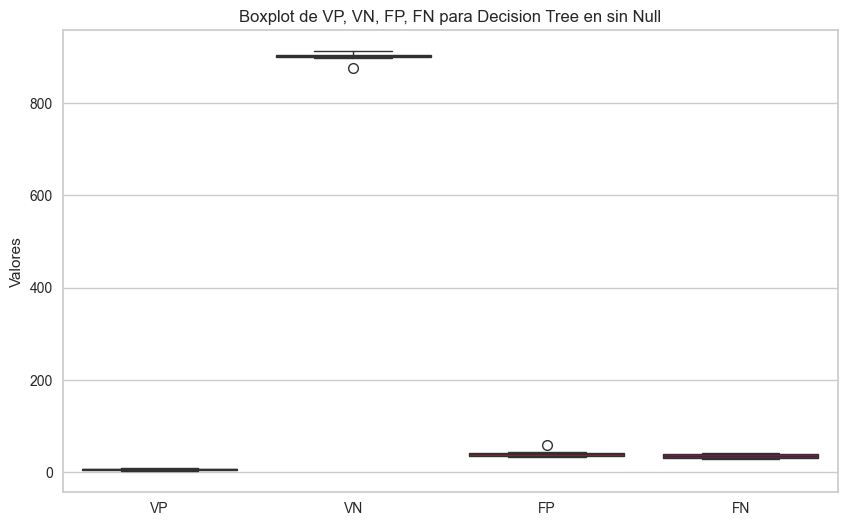

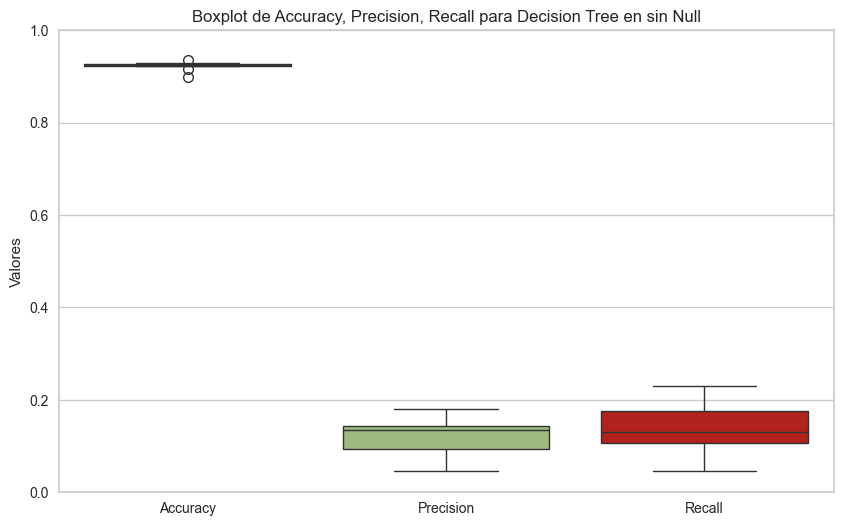

Decision Tree para el dataset sin Null balanceado:
	VP: 430.55555555555554, FN: 0.0 
	FP: 44.888888888888886, VN: 882.5555555555555
	Accuracy: 0.9669448535427916
	Precision: 0.9057800499782284
	Recall: 1.0


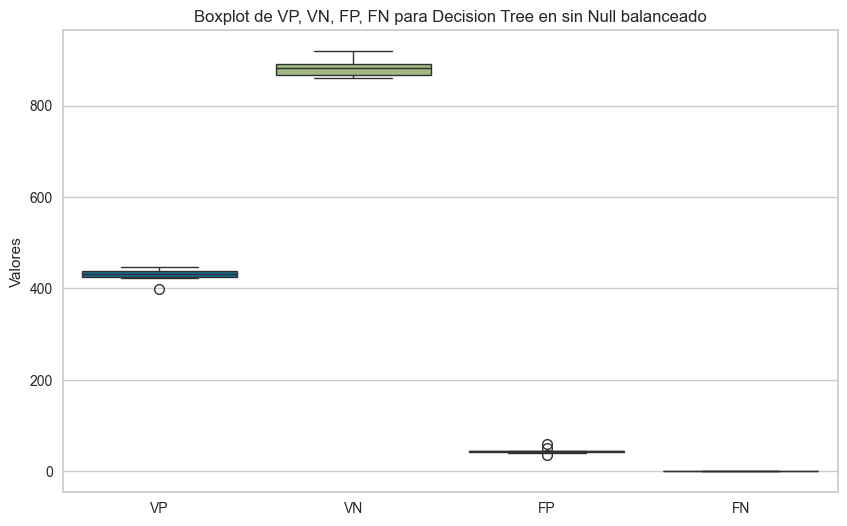

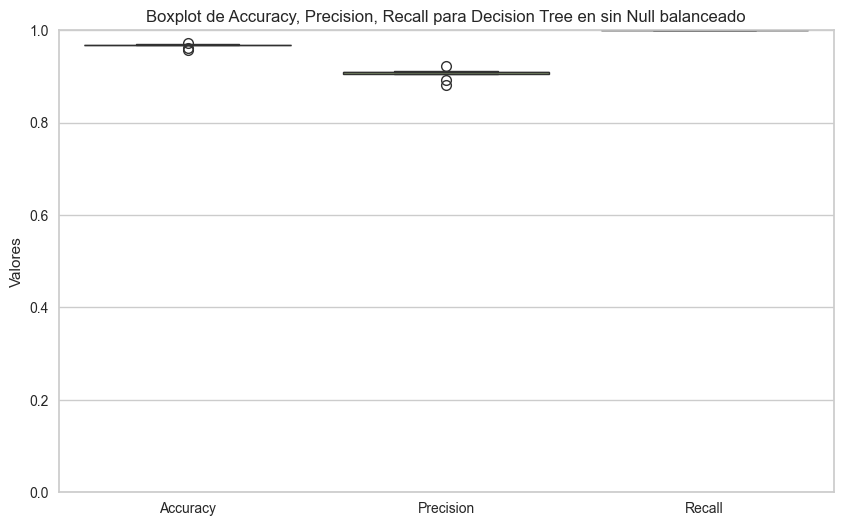

Decision Tree para el dataset sin IMC:
	VP: 8.777777777777779, FN: 41.333333333333336 
	FP: 49.888888888888886, VN: 922.0
	Accuracy: 0.910741465535986
	Precision: 0.15197038877830793
	Recall: 0.17497764649918937


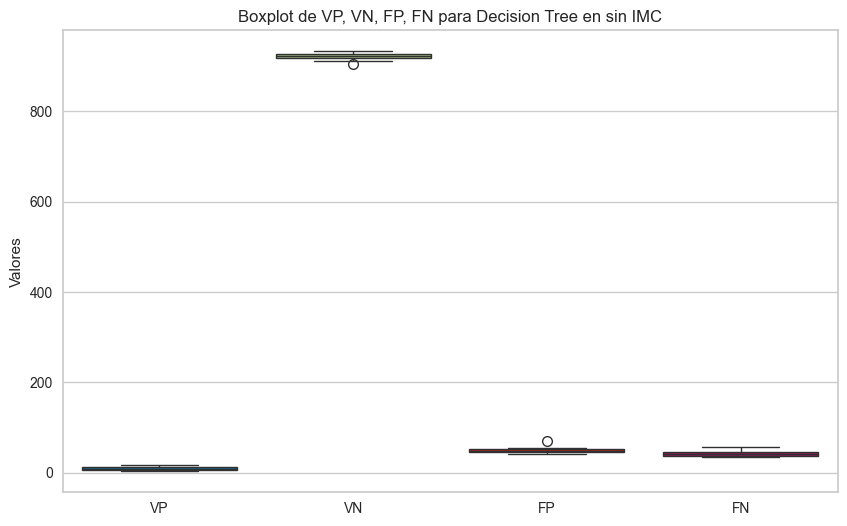

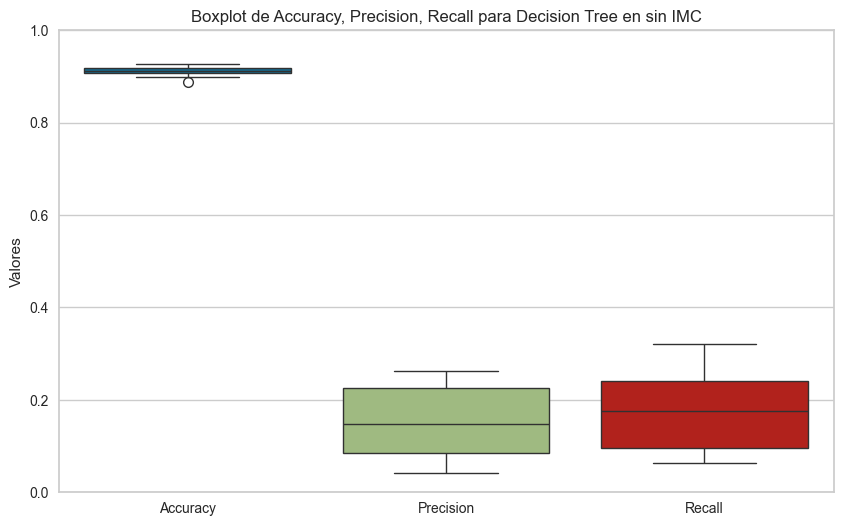

Decision Tree para el dataset sin IMC balanceado:
	VP: 491.55555555555554, FN: 0.0 
	FP: 52.333333333333336, VN: 927.1111111111111
	Accuracy: 0.9644232948107864
	Precision: 0.9037397940396732
	Recall: 1.0


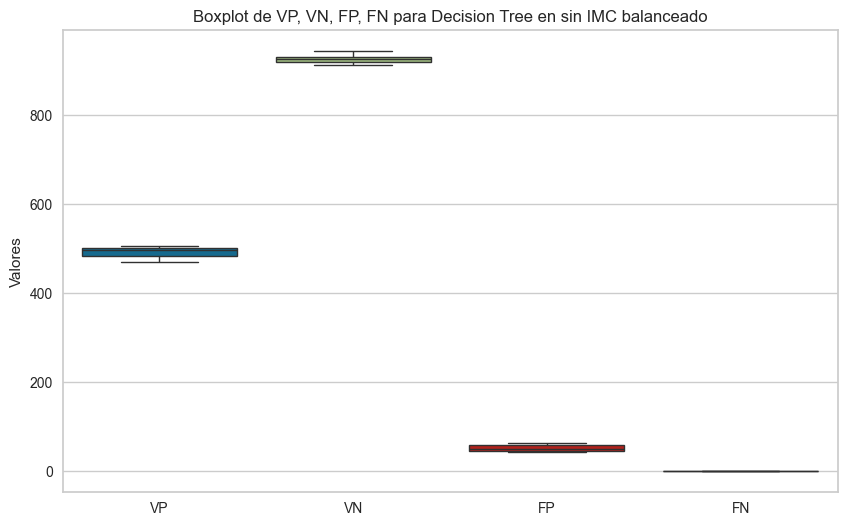

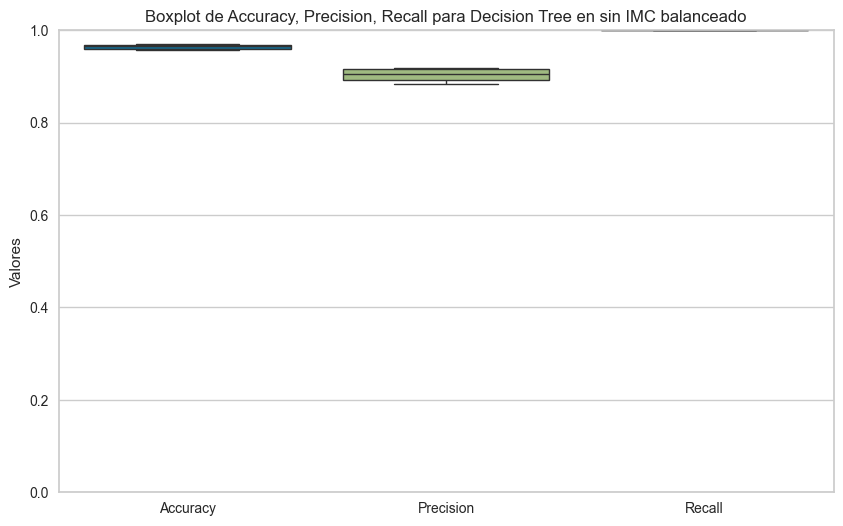

In [16]:
# Decision Tree
prueba_modelos(dataset, "Decision Tree", sk.tree.DecisionTreeClassifier(), "sin Null")
prueba_modelos(balanced_dataset, "Decision Tree", sk.tree.DecisionTreeClassifier(), "sin Null balanceado")
prueba_modelos2(dataset_no_bmi, "Decision Tree", sk.tree.DecisionTreeClassifier(), "sin IMC")
prueba_modelos2(balanced_dataset2, "Decision Tree", sk.tree.DecisionTreeClassifier(), "sin IMC balanceado")


In [ ]:
# Funcion para probar modelos KNN
def prueba_modelos_KNN(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []

    for k in range(1, 31):
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
            x_train, x_test, y_train, y_test = set_training_and_test(dataset)
            knn.fit(x_train, y_train)
            previsoes = knn.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), vp_proms, 'o-', label='VP')
    plt.plot(range(1, 31), vn_proms, 'o-', label='VN')
    plt.plot(range(1, 31), fp_proms, 'o-', label='FP')
    plt.plot(range(1, 31), fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), acc_proms, 'o-', label='Accuracy')
    plt.plot(range(1, 31), prec_proms, 'o-', label='Precision')
    plt.plot(range(1, 31), rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

def prueba_modelos_KNN2(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []

    for k in range(1, 31):
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=k)
            x_train, x_test, y_train, y_test = set_training_and_test2(dataset)
            knn.fit(x_train, y_train)
            previsoes = knn.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), vp_proms, 'o-', label='VP')
    plt.plot(range(1, 31), vn_proms, 'o-', label='VN')
    plt.plot(range(1, 31), fp_proms, 'o-', label='FP')
    plt.plot(range(1, 31), fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 31), acc_proms, 'o-', label='Accuracy')
    plt.plot(range(1, 31), prec_proms, 'o-', label='Precision')
    plt.plot(range(1, 31), rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
# KNN
prueba_modelos_KNN(dataset, "KNN", "sin Null")
prueba_modelos_KNN(balanced_dataset, "KNN", "sin Null balanceado")
prueba_modelos_KNN2(dataset_no_bmi, "KNN", "sin IMC")
prueba_modelos_KNN2(balanced_dataset2, "KNN", "sin IMC balanceado")


KeyboardInterrupt: 

In [29]:
# Funcion para probar modelos Random Forest
def prueba_modelos_RF(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []
    pruebas = [10, 20, 50, 100, 200, 500, 1000]

    for k in pruebas:
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            knn = RandomForestClassifier(n_estimators=k, random_state=random.randint(0, 100))
            x_train, x_test, y_train, y_test = set_training_and_test(dataset)
            knn.fit(x_train, y_train)
            previsoes = knn.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(pruebas, vp_proms, 'o-', label='VP')
    plt.plot(pruebas, vn_proms, 'o-', label='VN')
    plt.plot(pruebas, fp_proms, 'o-', label='FP')
    plt.plot(pruebas, fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(pruebas, acc_proms, 'o-', label='Accuracy')
    plt.plot(pruebas, prec_proms, 'o-', label='Precision')
    plt.plot(pruebas, rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

def prueba_modelos_RF2(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []
    pruebas = [10, 20, 50, 100, 200, 500, 1000]

    for k in pruebas:
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            knn = RandomForestClassifier(n_estimators=k, random_state=random.randint(0, 100))
            x_train, x_test, y_train, y_test = set_training_and_test2(dataset)
            knn.fit(x_train, y_train)
            previsoes = knn.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(pruebas, vp_proms, 'o-', label='VP')
    plt.plot(pruebas, vn_proms, 'o-', label='VN')
    plt.plot(pruebas, fp_proms, 'o-', label='FP')
    plt.plot(pruebas, fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(pruebas, acc_proms, 'o-', label='Accuracy')
    plt.plot(pruebas, prec_proms, 'o-', label='Precision')
    plt.plot(pruebas, rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
# Random Forest
prueba_modelos_RF(dataset, "Random Forest", "sin Null")
prueba_modelos_RF(balanced_dataset, "Random Forest", "sin Null balanceado")
prueba_modelos_RF2(dataset_no_bmi, "Random Forest", "sin IMC")
prueba_modelos_RF2(balanced_dataset2, "Random Forest", "sin IMC balanceado")

KeyboardInterrupt: 

In [31]:
# Función para probar modelos SVM
def prueba_modelos_SVM(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []
    kernel = ["linear", "poly", "rbf", "sigmoid"]

    for k in kernel:
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            svm = SVC(kernel=k, random_state=random.randint(0, 100))
            x_train, x_test, y_train, y_test = set_training_and_test(dataset)
            svm.fit(x_train, y_train)
            previsoes = svm.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(kernel, vp_proms, 'o-', label='VP')
    plt.plot(kernel, vn_proms, 'o-', label='VN')
    plt.plot(kernel, fp_proms, 'o-', label='FP')
    plt.plot(kernel, fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(kernel, acc_proms, 'o-', label='Accuracy')
    plt.plot(kernel, prec_proms, 'o-', label='Precision')
    plt.plot(kernel, rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()


def prueba_modelos_SVM2(dataset, model_name, dataset_name):
    # Listas para guardar los promedios de cada métrica por k
    vp_proms, vn_proms, fp_proms, fn_proms = [], [], [], []
    acc_proms, prec_proms, rec_proms = [], [], []
    kernel = ["linear", "poly", "rbf", "sigmoid"]

    for k in kernel:
        vp, vn, fp, fn = [], [], [], []
        accuracy, precision, recall = [], [], []
        for i in range(10):
            svm = SVC(kernel=k, random_state=random.randint(0, 100))
            x_train, x_test, y_train, y_test = set_training_and_test2(dataset)
            svm.fit(x_train, y_train)
            previsoes = svm.predict(x_test)

            vp.append(np.sum((previsoes == 1) & (y_test == 1)))
            vn.append(np.sum((previsoes == 0) & (y_test == 0)))
            fp.append(np.sum((previsoes == 1) & (y_test == 0)))
            fn.append(np.sum((previsoes == 0) & (y_test == 1)))
            accuracy.append((vp[-1] + vn[-1]) / len(y_test))
            precision.append(vp[-1] / (vp[-1] + fp[-1]) if (vp[-1] + fp[-1]) > 0 else 0)
            recall.append(vp[-1] / (vp[-1] + fn[-1]) if (vp[-1] + fn[-1]) > 0 else 0)

        # Guardar promedios para este k
        vp_proms.append(np.mean(vp))
        vn_proms.append(np.mean(vn))
        fp_proms.append(np.mean(fp))
        fn_proms.append(np.mean(fn))
        acc_proms.append(np.mean(accuracy))
        prec_proms.append(np.mean(precision))
        rec_proms.append(np.mean(recall))

    # Gráfica de VP, VN, FP, FN
    plt.figure(figsize=(12, 6))
    plt.plot(kernel, vp_proms, 'o-', label='VP')
    plt.plot(kernel, vn_proms, 'o-', label='VN')
    plt.plot(kernel, fp_proms, 'o-', label='FP')
    plt.plot(kernel, fn_proms, 'o-', label='FN')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'VP, VN, FP, FN promedio vs k para {model_name} en {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfica de Accuracy, Precision, Recall
    plt.figure(figsize=(12, 6))
    plt.plot(kernel, acc_proms, 'o-', label='Accuracy')
    plt.plot(kernel, prec_proms, 'o-', label='Precision')
    plt.plot(kernel, rec_proms, 'o-', label='Recall')
    plt.xlabel('k')
    plt.ylabel('Promedio')
    plt.title(f'Accuracy, Precision, Recall promedio vs k para {model_name} en {dataset_name}')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

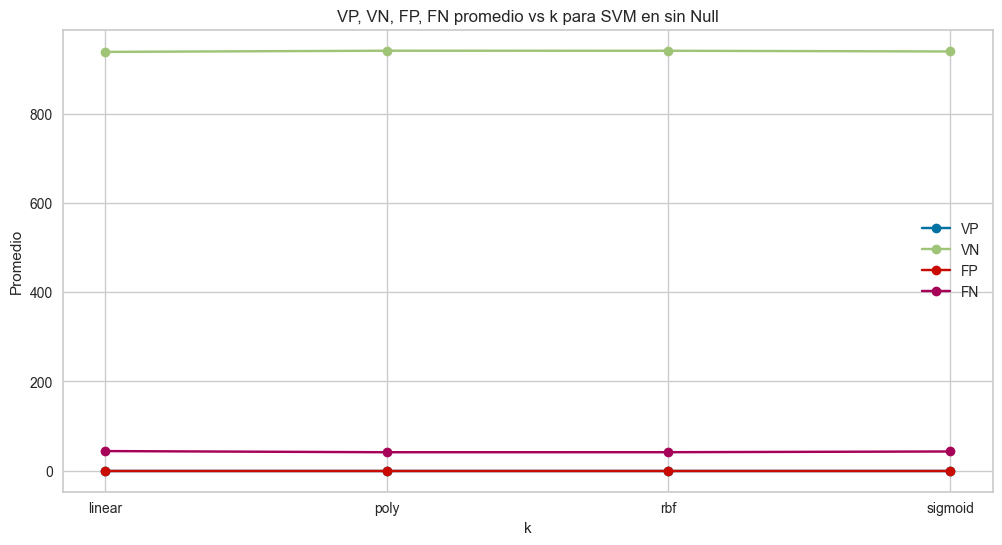

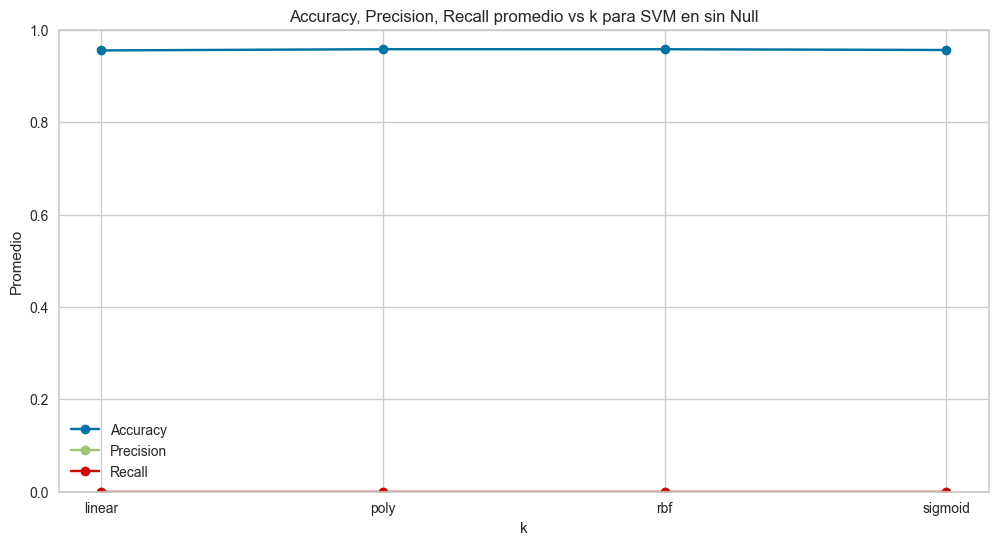

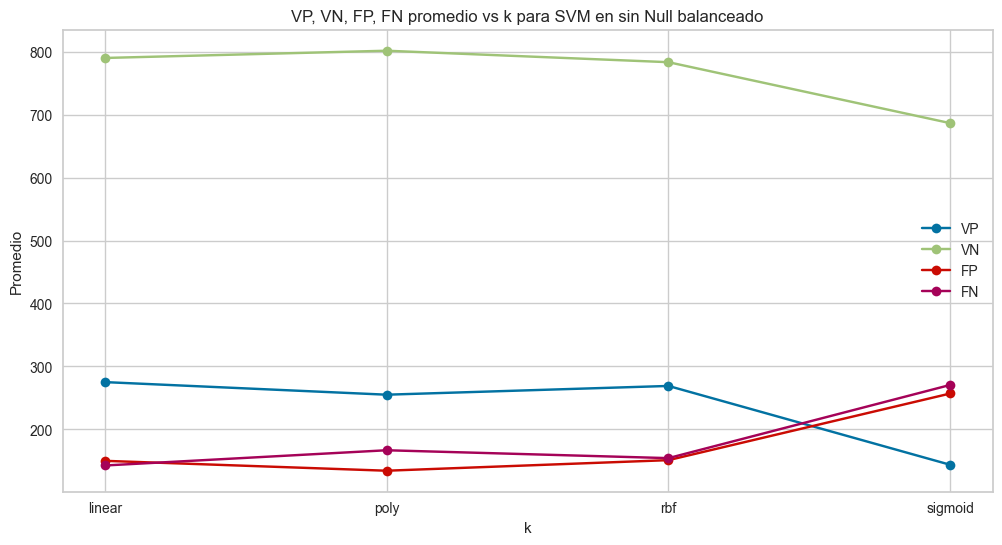

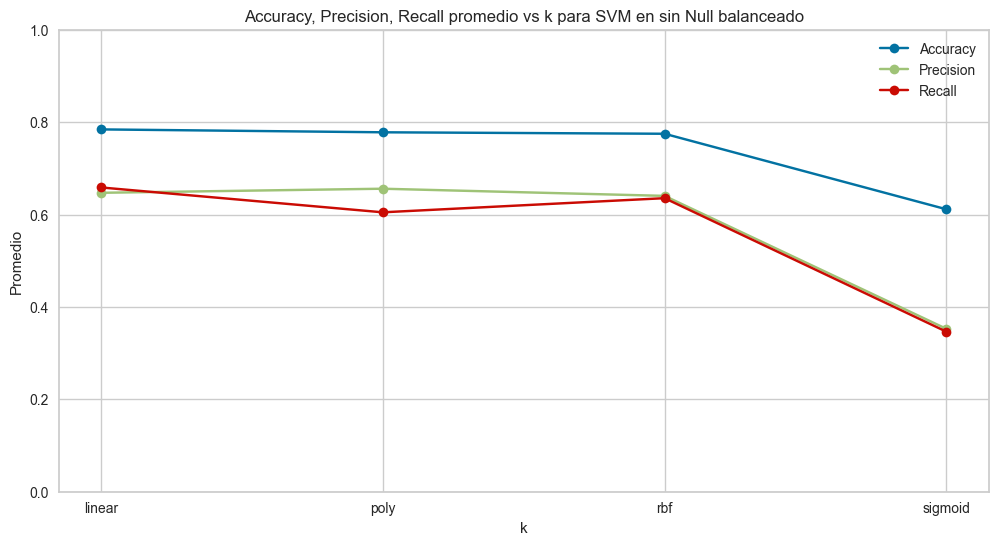

In [ ]:
# SVM
prueba_modelos_SVM(dataset, "SVM", "sin Null")
prueba_modelos_SVM(balanced_dataset, "SVM", "sin Null balanceado")
prueba_modelos_SVM2(dataset_no_bmi, "SVM", "sin IMC")
prueba_modelos_SVM2(balanced_dataset2, "SVM", "sin IMC balanceado")